In [4]:
pip install catboost


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e2/63/379617e3d982e8a66c9d66ebf4621d3357c7c18ad356473c335bffd5aba6/catboost-1.2.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------- --------------------- 20.5/47.0 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 584.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.0 MB 2.6 MB/s eta 0:00:39
   ---------------------------------------- 0.2/101.0 MB 2.5 MB/s eta 0:00:41
   ---------------------------------------- 0.3/101.0 MB 2.5 MB/s eta 0:00:41
   ---------------------------------------- 0.5/101.0 MB 2.6 MB/s eta 0:00:39
   ---------------------------------------- 0.6/101.0 MB 2.8 MB/s eta 0:00:37
   ----------------

In [5]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np

In [34]:

# Read the data
df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("test.csv")

# Drop patient_id column
df_train = df_train.drop("patient_id", axis=1)
df_test = df_test.drop("patient_id", axis=1)

numerical_cols = df_train.select_dtypes(exclude=['object']).columns
categorical_columns = df_train.select_dtypes(include=['object']).columns

# Impute categorical columns using mode
for col in categorical_columns:
    if col != 'DiagPeriodL90D':
        mode = df_train[col].mode()[0]
        df_train[col].fillna(mode, inplace=True)
        df_test[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        mean = df_train[col].median()
        df_train[col].fillna(mean, inplace=True)
        df_test[col].fillna(mean, inplace=True)

# Encoding categorical columns
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for col in categorical_columns.to_list() + ['patient_zip3']:
    encoder.fit(df_train[[col]])
    df_train[col] = encoder.transform(df_train[[col]])
    df_test[col] = encoder.transform(df_test[[col]])

cols = ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'patient_zip3', 'patient_race', 'patient_age', 'payer_type',
        'patient_state', 'breast_cancer_diagnosis_desc', 'Ozone', 'PM25', 'N02']

X_train = df_train[cols]
y_train = df_train['DiagPeriodL90D']

# Model parameters
params = {
    'depth': 2, # dont change this
    'random_state': 42,
    'eval_metric': 'AUC',
    'verbose': False,
    'loss_function': 'Logloss',
    'learning_rate': 0.35, # 0.815 was obtained at 0.3, to be experimented for further improvement
    'iterations': 1500, # dont change this
    'l2_leaf_reg': 3
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store AUC scores
auc_scores = []
test_preds = []

for train_idx, test_idx in cv.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Initialize CatBoost classifier
    model = CatBoostClassifier(**params)

    # Train the model
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold), use_best_model=True)

    # Make predictions
    preds = model.predict_proba(X_test_fold)[:, 1]
    preds_test = model.predict_proba(df_test[cols])[:, 1]
    test_preds.append(preds_test)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_fold, preds)
    auc_scores.append(auc_score)
    print(f"AUC Score: {auc_score}")

# Print average AUC score
print(f"Average AUC Score: {np.mean(auc_scores)}")

# Take the average of predictions for the test data
test_predictions = np.mean(test_preds, axis=0)

# # Convert predictions to binary using classification threshold
# test_predictions_binary = [1 if prob >= 0.5 else 0 for prob in test_predictions]

# # Print the distribution of predictions
# print(pd.Series(test_predictions_binary).value_counts())


AUC Score: 0.8072769307513239
AUC Score: 0.8019337681526835
AUC Score: 0.8011389680594715
AUC Score: 0.8108900736734553
AUC Score: 0.8077729720593997
Average AUC Score: 0.8058025425392668


In [ ]:
df_predictions = pd.DataFrame(test_predictions, columns=['predictions'])

df_test = pd.read_csv("test.csv")
df_predictions = pd.DataFrame({
    'patient_id': df_test['patient_id'],
    'predictions': test_predictions
})

df_predictions

df_predictions.to_csv('predictions.csv', index=False)


In [32]:
from sklearn.model_selection import GridSearchCV


In [35]:

# Define the parameter grid to search
param_grid = {
    'depth': [2, 4, 6 ,8, 10],  # Experiment with different values for depth
    'learning_rate': [0.1, 0.2, 0.25, 0.3, 0.35, 0.4],
    'l2_leaf_reg': [3],
    'iterations': [1000, 1500, 2000, 2500]  # Experiment with different values for iterations
}

# Initialize CatBoost classifier
model = CatBoostClassifier(random_state=42, eval_metric='AUC', verbose=False, loss_function='Logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_) 
print("Best AUC Score:", grid_search.best_score_)

Best Parameters: {'depth': 2, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Best AUC Score: 0.8015686174850833


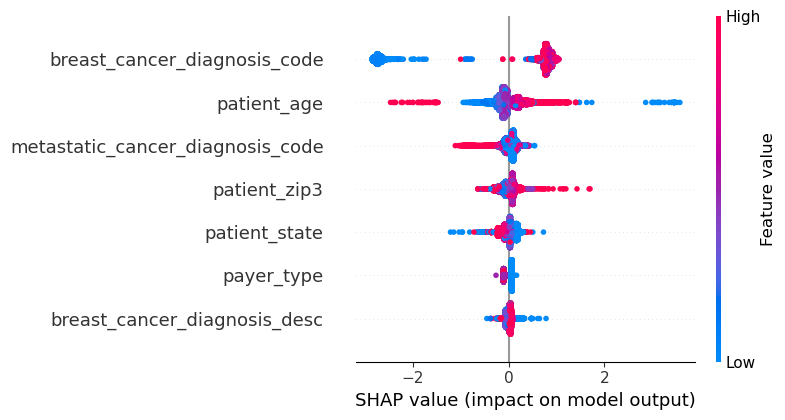

Important Features: Index(['breast_cancer_diagnosis_desc', 'payer_type', 'patient_state',
       'patient_zip3', 'metastatic_cancer_diagnosis_code', 'patient_age',
       'breast_cancer_diagnosis_code'],
      dtype='object')


In [8]:
# import shap

# # Calculate SHAP values
# explainer = shap.Explainer(model)
# shap_values = explainer.shap_values(X_train)

# # Aggregate SHAP values
# shap.summary_plot(shap_values, X_train)

# # Identify important features
# mean_abs_shap = np.abs(shap_values).mean(axis=0)
# important_features = X_train.columns[np.argsort(mean_abs_shap)]# [::-1][:10]]  # Select top 5 important features
# print("Important Features:", important_features)

Important Features: Index(['breast_cancer_diagnosis_desc', 'payer_type', 'patient_state',
       'patient_zip3', 'metastatic_cancer_diagnosis_code', 'patient_age',
       'breast_cancer_diagnosis_code']

# # Refit the model using only important features
# X_train_reduced = X_train[important_features]

# # List to store AUC scores for the model with reduced features
# auc_scores_reduced = []
# test_preds_reduced = []

# for train_idx, test_idx in cv.split(X_train_reduced, y_train):
#     X_train_fold, X_test_fold = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[test_idx]
#     y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

#     # Initialize CatBoost classifier
#     model_reduced = CatBoostClassifier(**params)

#     # Train the model with reduced features
#     model_reduced.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold), use_best_model=True)

#     # Make predictions
#     preds_reduced = model_reduced.predict_proba(X_test_fold)[:, 1]
#     preds_test_reduced = model_reduced.predict_proba(df_test[important_features])[:, 1]
#     test_preds_reduced.append(preds_test_reduced)

#     # Calculate AUC score
#     auc_score_reduced = roc_auc_score(y_test_fold, preds_reduced)
#     auc_scores_reduced.append(auc_score_reduced)
#     print(f"AUC Score with reduced features: {auc_score_reduced}")

# # Print average AUC score with reduced features
# print(f"Average AUC Score with reduced features: {np.mean(auc_scores_reduced)}")

# # Take the average of predictions for the test data using reduced features
# test_predictions_reduced = np.mean(test_preds_reduced, axis=0)

# # Create submission dataframe
# submission_reduced = pd.read_csv('/Users/yujata/widsdatathon2024-challenge1/submission.csv')
# submission_reduced['DiagPeriodL90D'] = test_predictions_reduced

# # Save submission file with reduced features
# submission_reduced.to_csv('submission_reduced.csv', index=False)


In [ ]:
## IMPORTANT FEATURES - 0.814

In [13]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
import shap

# Read the data
df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("test.csv")

# Drop patient_id column
df_train = df_train.drop("patient_id", axis=1)
df_test = df_test.drop("patient_id", axis=1)

numerical_cols = df_train.select_dtypes(exclude=['object']).columns
categorical_columns = df_train.select_dtypes(include=['object']).columns

# Impute categorical columns using mode
for col in categorical_columns:
    if col != 'DiagPeriodL90D':
        mode = df_train[col].mode()[0]
        df_train[col].fillna(mode, inplace=True)
        df_test[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        mean = df_train[col].median()
        df_train[col].fillna(mean, inplace=True)
        df_test[col].fillna(mean, inplace=True)

# Encoding categorical columns
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for col in categorical_columns.to_list() + ['patient_zip3']:
    encoder.fit(df_train[[col]])
    df_train[col] = encoder.transform(df_train[[col]])
    df_test[col] = encoder.transform(df_test[[col]])

important_features = ['breast_cancer_diagnosis_desc', 'payer_type', 'patient_state',
                      'patient_zip3', 'metastatic_cancer_diagnosis_code', 'patient_age',
                      'breast_cancer_diagnosis_code']

X_train = df_train[important_features]
y_train = df_train['DiagPeriodL90D']

# Model parameters
params = {
    'depth': 2, # don't change this
    'random_state': 42,
    'eval_metric': 'AUC',
    'verbose': False,
    'loss_function': 'Logloss',
    'learning_rate': 0.3, # 0.815 was obtained at 0.3, to be experimented for further improvement
    'iterations': 1400, # don't change this
    'l2_leaf_reg': 3
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store AUC scores
auc_scores = []
test_preds = []

for train_idx, test_idx in cv.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Initialize CatBoost classifier
    model = CatBoostClassifier(**params)

    # Train the model
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold), use_best_model=True)

    # Make predictions
    preds = model.predict_proba(X_test_fold)[:, 1]
    preds_test = model.predict_proba(df_test[important_features])[:, 1]
    test_preds.append(preds_test)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_fold, preds)
    auc_scores.append(auc_score)
    print(f"AUC Score: {auc_score}")

# Print average AUC score
print(f"Average AUC Score: {np.mean(auc_scores)}")

# Take the average of predictions for the test data
test_predictions = np.mean(test_preds, axis=0)

# Create submission dataframe
submission = pd.read_csv('/Users/yujata/widsdatathon2024-challenge1/submission.csv')
submission['DiagPeriodL90D'] = test_predictions

# Save submission file
submission.to_csv('submission.csv', index=False)


AUC Score: 0.8172728377375866
AUC Score: 0.8065927755456368
AUC Score: 0.80169593630844
AUC Score: 0.8063232541286072
AUC Score: 0.8016770506034462
Average AUC Score: 0.8067123708647435


In [ ]:
## transformation(min-max) + feature importance : 0.813

In [15]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Read the data
df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("test.csv")

# Drop patient_id column
df_train = df_train.drop("patient_id", axis=1)
df_test = df_test.drop("patient_id", axis=1)

numerical_cols = df_train.select_dtypes(exclude=['object']).columns
categorical_columns = df_train.select_dtypes(include=['object']).columns

# Impute categorical columns using mode
for col in categorical_columns:
    if col != 'DiagPeriodL90D':
        mode = df_train[col].mode()[0]
        df_train[col].fillna(mode, inplace=True)
        df_test[col].fillna(mode, inplace=True)

# Impute numerical columns using median
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        median = df_train[col].median()
        df_train[col].fillna(median, inplace=True)
        df_test[col].fillna(median, inplace=True)

# Encoding categorical columns
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for col in categorical_columns.to_list() + ['patient_zip3']:
    encoder.fit(df_train[[col]])
    df_train[col] = encoder.transform(df_train[[col]])
    df_test[col] = encoder.transform(df_test[[col]])

important_features = ['breast_cancer_diagnosis_desc', 'payer_type', 'patient_state',
                      'patient_zip3', 'metastatic_cancer_diagnosis_code', 'patient_age',
                      'breast_cancer_diagnosis_code']

X_train = df_train[important_features]
y_train = df_train['DiagPeriodL90D']

# Min-Max Scaling for numerical features
scaler = MinMaxScaler()
X_train[important_features] = scaler.fit_transform(X_train[important_features])
df_test[important_features] = scaler.transform(df_test[important_features])

# Model parameters
params = {
    'depth': 2, # don't change this
    'random_state': 42,
    'eval_metric': 'AUC',
    'verbose': False,
    'loss_function': 'Logloss',
    'learning_rate': 0.3, # 0.815 was obtained at 0.3, to be experimented for further improvement
    'iterations': 1400, # don't change this
    'l2_leaf_reg': 3
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store AUC scores
auc_scores = []
test_preds = []

for train_idx, test_idx in cv.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Initialize CatBoost classifier
    model = CatBoostClassifier(**params)

    # Train the model
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold), use_best_model=True)

    # Make predictions
    preds = model.predict_proba(X_test_fold)[:, 1]
    preds_test = model.predict_proba(df_test[important_features])[:, 1]
    test_preds.append(preds_test)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_fold, preds)
    auc_scores.append(auc_score)
    print(f"AUC Score: {auc_score}")

# Print average AUC score
print(f"Average AUC Score: {np.mean(auc_scores)}")

# Take the average of predictions for the test data
test_predictions = np.mean(test_preds, axis=0)

# Create submission dataframe
submission = pd.read_csv('/Users/yujata/widsdatathon2024-challenge1/submission.csv')
submission['DiagPeriodL90D'] = test_predictions

# Save submission file
submission.to_csv('submission.csv', index=False)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AUC Score: 0.8172728377375866
AUC Score: 0.8065927755456368
AUC Score: 0.80169593630844
AUC Score: 0.8063232541286072
AUC Score: 0.8016799314736995
Average AUC Score: 0.8067129470387939


In [ ]:
## transformation(standard scaler) + feature importance : 0.814

In [17]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np

# Read the data
df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("test.csv")

# Drop patient_id column
df_train = df_train.drop("patient_id", axis=1)
df_test = df_test.drop("patient_id", axis=1)

numerical_cols = df_train.select_dtypes(exclude=['object']).columns
categorical_columns = df_train.select_dtypes(include=['object']).columns

# Impute categorical columns using mode
for col in categorical_columns:
    if col != 'DiagPeriodL90D':
        mode = df_train[col].mode()[0]
        df_train[col].fillna(mode, inplace=True)
        df_test[col].fillna(mode, inplace=True)

# Impute numerical columns using median
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        median = df_train[col].median()
        df_train[col].fillna(median, inplace=True)
        df_test[col].fillna(median, inplace=True)

# Encoding categorical columns
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for col in categorical_columns.to_list() + ['patient_zip3']:
    encoder.fit(df_train[[col]])
    df_train[col] = encoder.transform(df_train[[col]])
    df_test[col] = encoder.transform(df_test[[col]])

important_features = ['breast_cancer_diagnosis_desc', 'payer_type', 'patient_state',
                      'patient_zip3', 'metastatic_cancer_diagnosis_code', 'patient_age',
                      'breast_cancer_diagnosis_code']

X_train = df_train[important_features]
y_train = df_train['DiagPeriodL90D']

# Standard Scaling for numerical features
scaler = StandardScaler()
X_train[important_features] = scaler.fit_transform(X_train[important_features])
df_test[important_features] = scaler.transform(df_test[important_features])

# Model parameters
params = {
    'depth': 2, # don't change this
    'random_state': 42,
    'eval_metric': 'AUC',
    'verbose': False,
    'loss_function': 'Logloss',
    'learning_rate': 0.24515031722301922, # 0.815 was obtained at 0.3, to be experimented for further improvement
    'iterations': 1400, # don't change this
    'l2_leaf_reg': 3.9982444244455304
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store AUC scores
auc_scores = []
test_preds = []

for train_idx, test_idx in cv.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Initialize CatBoost classifier
    model = CatBoostClassifier(**params)

    # Train the model
    model.fit(X_train_fold, y_train_fold, eval_set=(X_test_fold, y_test_fold), use_best_model=True)

    # Make predictions
    preds = model.predict_proba(X_test_fold)[:, 1]
    preds_test = model.predict_proba(df_test[important_features])[:, 1]
    test_preds.append(preds_test)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_fold, preds)
    auc_scores.append(auc_score)
    print(f"AUC Score: {auc_score}")

# Print average AUC score
print(f"Average AUC Score: {np.mean(auc_scores)}")

# Take the average of predictions for the test data
test_predictions = np.mean(test_preds, axis=0)

# Create submission dataframe
submission = pd.read_csv('/Users/yujata/widsdatathon2024-challenge1/submission.csv')
submission['DiagPeriodL90D'] = test_predictions

# Save submission file
submission.to_csv('submission.csv', index=False)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


AUC Score: 0.8130896497915121
AUC Score: 0.8033277892585792
AUC Score: 0.8003896216969222
AUC Score: 0.8048354446911323
AUC Score: 0.8038697129628919
Average AUC Score: 0.8051024436802076


In [ ]:
## XGBOOST : 0.813

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np

# Read the data
df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("test.csv")

# Drop patient_id column
df_train = df_train.drop("patient_id", axis=1)
df_test = df_test.drop("patient_id", axis=1)

numerical_cols = df_train.select_dtypes(exclude=['object']).columns
categorical_columns = df_train.select_dtypes(include=['object']).columns

# Impute categorical columns using mode
for col in categorical_columns:
    if col != 'DiagPeriodL90D':
        mode = df_train[col].mode()[0]
        df_train[col].fillna(mode, inplace=True)
        df_test[col].fillna(mode, inplace=True)

# Impute numerical columns using median
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        median = df_train[col].median()
        df_train[col].fillna(median, inplace=True)
        df_test[col].fillna(median, inplace=True)

# Encoding categorical columns
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for col in categorical_columns.to_list() + ['patient_zip3']:
    encoder.fit(df_train[[col]])
    df_train[col] = encoder.transform(df_train[[col]])
    df_test[col] = encoder.transform(df_test[[col]])

important_features = ['breast_cancer_diagnosis_desc', 'payer_type', 'patient_state',
                      'patient_zip3', 'metastatic_cancer_diagnosis_code', 'patient_age',
                      'breast_cancer_diagnosis_code']

X_train = df_train[important_features]
y_train = df_train['DiagPeriodL90D']

# Standard Scaling for numerical features
scaler = StandardScaler()
X_train[important_features] = scaler.fit_transform(X_train[important_features])
df_test[important_features] = scaler.transform(df_test[important_features])

# Best parameters
best_params = {'learning_rate': 0.24515031722301922, 'max_depth': 2, 'n_estimators': 297, 'reg_lambda': 3.9982444244455304}

# Model parameters
params = {
    'random_state': 42,
    'eval_metric': 'auc',
    **best_params
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List to store AUC scores
auc_scores = []
test_preds = []

for train_idx, test_idx in cv.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Initialize XGBoost classifier
    model = XGBClassifier(**params)

    # Train the model
    model.fit(X_train_fold, y_train_fold)

    # Make predictions
    preds = model.predict_proba(X_test_fold)[:, 1]
    preds_test = model.predict_proba(df_test[important_features])[:, 1]
    test_preds.append(preds_test)

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_fold, preds)
    auc_scores.append(auc_score)
    print(f"AUC Score: {auc_score}")

# Print average AUC score
print(f"Average AUC Score: {np.mean(auc_scores)}")

# Take the average of predictions for the test data
test_predictions = np.mean(test_preds, axis=0)

# Create submission dataframe
submission = pd.read_csv('/Users/yujata/widsdatathon2024-challenge1/submission.csv')
submission['DiagPeriodL90D'] = test_predictions

# Save submission file
submission.to_csv('submission.csv', index=False)
